In [1]:
# %matplotlib widget 

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
sc.settings.verbosity = 0
#from anndata import AnnData
import scipy
#from numpy.linalg import svd

In [3]:
try:
    from sys import path as syspath
    from os import path as ospath
    syspath.append(ospath.join(ospath.expanduser("~"), 'Documents/git/Xct'))

    from scTenifoldXct.main import *
    import scTenifoldXct.dNN as dNN    
    import scTenifoldXct.visualization as vis
    
except ImportError:
    print('Module not found')

In [4]:
ada = sc.read_h5ad("../data/HCC_processed_v2.h5ad")
ada

AnnData object with n_obs × n_vars = 4096 × 2608
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain', 'patient_id', 'patient_tumorsection', 'NormalvsTumor', 'patientno', 'PNC', 'PIC', 'ViralvsNonViral', 'ident', 'batch'
    var: 'gene_ids', 'n_cells'
    obsm: 'X_pca', 'X_umap'
    layers: 'log1p', 'raw'

In [5]:
#ada.obs.rename({'indent': 'ident'}, axis=1, inplace=True)

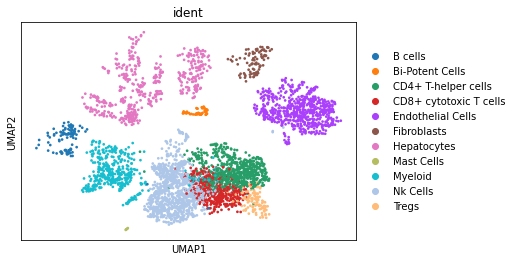

In [6]:
sc.pl.umap(ada, color='ident')

In [7]:
ada_N = ada[ada.obs['NormalvsTumor'] == 'N', :].copy()
ada_T = ada[ada.obs['NormalvsTumor'] == 'T', :].copy()
ada_N.shape, ada_T.shape

((2057, 2608), (2039, 2608))

In [8]:
ada_T.obs['ident'].value_counts()

Hepatocytes               462
CD4+ T-helper cells       422
CD8+ cytotoxic T cells    273
Endothelial Cells         272
Nk Cells                  221
Myeloid                   189
Tregs                      99
Fibroblasts                59
B cells                    39
Mast Cells                  2
Bi-Potent Cells             1
Name: ident, dtype: int64

In [9]:
ada_N.obs['ident'].value_counts()

Nk Cells                  801
Endothelial Cells         386
CD4+ T-helper cells       260
Myeloid                   225
CD8+ cytotoxic T cells    191
B cells                    65
Bi-Potent Cells            53
Fibroblasts                36
Tregs                      19
Hepatocytes                18
Mast Cells                  3
Name: ident, dtype: int64

## tumor vs adjacent normal:

In [10]:
# obj_T = Xct(ada_T, 'Hepatocytes', 'Endothelial Cells', build_GRN = True, save_GRN = True, 
#           pcNet_name = 'Net_Hep2Endo_T', mode = 'full', verbose=True)

obj_T = Xct(ada_T, 'Hepatocytes', 'Endothelial Cells', build_GRN = False,
           pcNet_name = 'Net_Hep2Endo_T')

print(obj_T)

Xct object for interactions from Hepatocytes (462) to Endothelial Cells (272)
# of genes = 2608 X 2608 
Correspondence = 5216 X 5216


In [11]:
df1_T = obj_T.fill_metric()
df1_T

,ligand,receptor,mean_L,mean_R,var_L,var_R
186,NID1,PTPRF,0.033262,0.005097,0.025957,0.003507
271,IL1B,PLAUR,0.001500,0.036930,0.001038,0.032931
274,KNG1,PLAUR,0.523149,0.036930,0.689779,0.032931
275,VTN,PLAUR,1.317913,0.036930,2.115814,0.032931
276,PLG,PLAUR,0.148717,0.036930,0.169688,0.032931
...,...,...,...,...,...,...
7967,ANGPTL4,GPIHBP1,0.092515,0.040536,0.083921,0.033514
7979,S100A8,CD68,0.001500,0.005097,0.001038,0.003507
7980,S100A9,CD68,0.055646,0.005097,0.113773,0.003507
7984,TF,TFR2,0.697570,0.002548,0.913951,0.001760


In [12]:
# obj1_N = Xct(ada_N, 'Hepatocytes', 'Endothelial Cells', build_GRN = True, save_GRN = True, 
#           pcNet_name = 'Net_Hep2Endo_N', mode = 'full', verbose=True)


obj_N = Xct(ada_N, 'Hepatocytes', 'Endothelial Cells', build_GRN = False,
           pcNet_name = 'Net_Hep2Endo_N')

print(obj_N)

Xct object for interactions from Hepatocytes (18) to Endothelial Cells (386)
# of genes = 2608 X 2608 
Correspondence = 5216 X 5216


In [13]:
df1_N = obj_N.fill_metric()
df1_N

,ligand,receptor,mean_L,mean_R,var_L,var_R
274,KNG1,PLAUR,0.138050,0.113438,0.101378,0.103768
275,VTN,PLAUR,0.495614,0.113438,0.467505,0.103768
276,PLG,PLAUR,0.077016,0.113438,0.047452,0.103768
375,APOE,APP,0.276101,0.375405,0.164641,0.243506
393,IGF2,PDGFRB,0.099542,0.024354,0.083836,0.028555
...,...,...,...,...,...,...
7440,SAA1,SCARB1,0.381496,0.016161,0.363564,0.010941
7442,APOE,SCARB1,0.276101,0.016161,0.164641,0.010941
7728,HP,ASGR1,1.230502,0.010774,1.034765,0.007352
7967,ANGPTL4,GPIHBP1,0.038508,0.081515,0.025209,0.084282


In [14]:
#selected LR pairs
candidates_T = get_candidates(df1_T)
print(len(candidates_T))

candidates_N = get_candidates(df1_N)
print(len(candidates_N))

314
101


In [15]:
candidates_union = list(set(candidates_T).union(set(candidates_N)))
len(candidates_union)

337

In [16]:
candidates_inter = list(set(candidates_T).intersection(set(candidates_N)))
len(candidates_inter)

78

## mode 'full':

In [17]:
obj_T._w.shape, obj_N._w.shape

((5216, 5216), (5216, 5216))

In [18]:
counts_np1 = get_counts_np(obj_T, obj_N)
len(counts_np1), counts_np1[0].shape, counts_np1[1].shape, counts_np1[2].shape, counts_np1[3].shape

(4, (2608, 462), (2608, 272), (2608, 18), (2608, 386))

In [19]:
W = build_W(obj_T, obj_N)
W.shape

(10432, 10432)

In [20]:
projections, losses = dNN.train_and_project(counts_np1, w = W, dim = 3, steps = 1000, lr = 0.01)

Net(
  (linear1): Linear(in_features=462, out_features=148, bias=True)
  (linear2): Linear(in_features=148, out_features=37, bias=True)
  (linear3): Linear(in_features=37, out_features=3, bias=True)
)
Net(
  (linear1): Linear(in_features=272, out_features=112, bias=True)
  (linear2): Linear(in_features=112, out_features=28, bias=True)
  (linear3): Linear(in_features=28, out_features=3, bias=True)
)
Net(
  (linear1): Linear(in_features=18, out_features=28, bias=True)
  (linear2): Linear(in_features=28, out_features=7, bias=True)
  (linear3): Linear(in_features=7, out_features=3, bias=True)
)
Net(
  (linear1): Linear(in_features=386, out_features=136, bias=True)
  (linear2): Linear(in_features=136, out_features=34, bias=True)
  (linear3): Linear(in_features=34, out_features=3, bias=True)
)
1 11606.599609375
10 8119.80322265625
20 6010.48583984375
30 5814.9384765625
40 5657.8916015625
50 5619.93798828125
60 5578.1376953125
70 5547.01611328125
80 5518.3154296875
90 5491.13671875
100 5463.9

In [21]:
projections.shape

(10432, 3)

In [22]:
projections_split = np.array_split(projections, 2) #return a list of ndarray
projections_split[0].shape, projections_split[1].shape

((5216, 3), (5216, 3))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(figsize=(8,8), dpi=80)
ax = Axes3D(fig)

ax.scatter(projections_split[0][:2608, 0], projections_split[0][:2608, 1], projections_split[0][:2608, 2], c='red')
ax.scatter(projections_split[0][2608:, 0], projections_split[0][2608:, 1], projections_split[0][2608:, 2], c='blue')

ax.scatter(projections_split[1][:2608, 0], projections_split[1][:2608, 1], projections_split[1][:2608, 2], c='black')
ax.scatter(projections_split[1][2608:, 0], projections_split[1][2608:, 1], projections_split[1][2608:, 2], c='green')

# for ii in range(0,360,30):
#     ax.view_init(elev=10., azim=ii)
#     plt.savefig("movie%d.png" % ii)

plt.show()

In [23]:
df_nn_T = nn_aligned_dist(obj_T, projections_split[0], dist_metric = 'euclidean') # euclidean, mahalanobis
df_nn_N = nn_aligned_dist(obj_N, projections_split[1], dist_metric = 'euclidean')


df_nn_T.head()

computing pair-wise euclidean distances...
adding column 'correspondence'...
computing pair-wise euclidean distances...
adding column 'correspondence'...


,ligand,receptor,dist,correspondence
FO538757.2_FO538757.2,FO538757.2,FO538757.2,0.017250,0.091134
FO538757.2_KLHL17,FO538757.2,KLHL17,0.031053,0.012171
FO538757.2_HES4,FO538757.2,HES4,0.019890,0.012171
FO538757.2_AGRN,FO538757.2,AGRN,0.011269,0.330366
FO538757.2_TNFRSF4,FO538757.2,TNFRSF4,0.010589,0.550417


In [24]:
df_nn_all = nn_aligned_dist_diff(df_nn_T, df_nn_N)

df_nn_all

computing pair-wise distance differences...
adding column 'diff2'...


,ligand,receptor,dist,correspondence,dist,correspondence,diff2
FO538757.2_FO538757.2,FO538757.2,FO538757.2,0.017250,0.091134,0.018049,0.191655,6.390791e-07
FO538757.2_KLHL17,FO538757.2,KLHL17,0.031053,0.012171,0.027176,0.000000,1.502721e-05
FO538757.2_HES4,FO538757.2,HES4,0.019890,0.012171,0.016465,0.096054,1.173500e-05
FO538757.2_AGRN,FO538757.2,AGRN,0.011269,0.330366,0.011297,0.505871,8.229912e-10
FO538757.2_TNFRSF4,FO538757.2,TNFRSF4,0.010589,0.550417,0.012934,0.450030,5.502717e-06
...,...,...,...,...,...,...,...
AL354822.1_LSS,AL354822.1,LSS,0.027701,0.005324,0.031409,0.000000,1.375380e-05
AL354822.1_MCM3AP,AL354822.1,MCM3AP,0.025766,0.005621,0.029363,0.000000,1.293816e-05
AL354822.1_C21orf58,AL354822.1,C21orf58,0.025601,0.001255,0.028123,0.000000,6.363024e-06
AL354822.1_S100B,AL354822.1,S100B,0.024762,0.000000,0.024611,0.000000,2.273995e-08


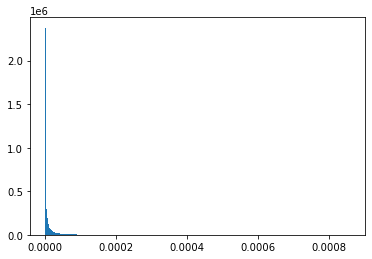

In [25]:
plt.figure()

plt.hist(df_nn_all['diff2'], bins=1000)
plt.show()


Total enriched: 11 / 6801664


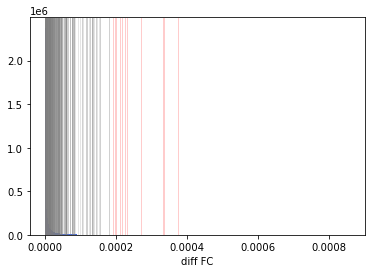

,ligand,receptor,dist,correspondence,dist,correspondence,diff2,FC,p_val,q_val,enriched_rank,dir,dir_sign
PLA2G2A_ITGA5,PLA2G2A,ITGA5,0.000966,63.442886,0.020330,0.000000,0.000375,25.919938,3.558744e-07,0.000874,1,1,↑
TFF3_ACKR3,TFF3,ACKR3,0.014729,4.894422,0.033027,0.000000,0.000335,23.144492,1.502730e-06,0.001622,2,1,↑
IGF2_PDGFRB,IGF2,PDGFRB,0.028989,0.002204,0.010817,1.563339,0.000330,22.826248,1.773273e-06,0.001763,3,0,↓
IGF2_FGFR3,IGF2,FGFR3,0.026896,0.008800,0.010493,1.164751,0.000269,18.598575,1.613411e-05,0.006167,4,0,↓
MDK_PTPRB,MDK,PTPRB,0.004120,18.164612,0.019291,0.000000,0.000230,15.911360,6.637912e-05,0.015390,5,1,↑
CXCL3_ACKR1,CXCL3,ACKR1,0.007820,9.877164,0.022808,0.000000,0.000225,15.529695,8.121932e-05,0.017529,6,1,↑
MDK_ITGA6,MDK,ITGA6,0.005910,9.732614,0.020618,0.000000,0.000216,14.952892,1.102290e-04,0.021382,7,1,↑
SPP1_ITGA5,SPP1,ITGA5,0.005787,9.508539,0.020330,0.000000,0.000211,14.620188,1.314983e-04,0.023883,8,1,↑
IGF2_ERBB2,IGF2,ERBB2,0.027518,0.004406,0.013460,0.133888,0.000198,13.660371,2.190282e-04,0.033280,9,0,↓
SPP1_ITGB5,SPP1,ITGB5,0.017272,0.855795,0.031227,0.000000,0.000195,13.462288,2.434068e-04,0.035624,10,1,↑


In [26]:
df_enriched_diff = chi2_diff_test(df_nn_all, df=1, pval=0.05, FDR=True, candidates=candidates_union, plot=True)
df_enriched_diff

In [ ]:
# df_enriched_diff.to_excel('HCC_compare.xlsx')

#### GSEA:

In [27]:
df_enriched_up = df_enriched_diff[df_enriched_diff['dir'] == 1]

genelist = get_genelist(df_enriched_up) # saveas='heart_diff'
len(genelist)

11

In [28]:
genelist

['ACKR1',
 'ITGB5',
 'ITGA5',
 'MDK',
 'SPP1',
 'TFF3',
 'PLA2G2A',
 'ACKR3',
 'ITGA6',
 'CXCL3',
 'PTPRB']

In [30]:
import gseapy as gp

enr = gp.enrichr(gene_list= genelist,
                 gene_sets= 'BioPlanet_2019', #'GO_Biological_Process_2021',
                 organism='Human', 
                 outdir=None, #'enrichr_kegg',
                 no_plot=True,
                 cutoff=0.05 
                )

In [31]:
enr.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,BioPlanet_2019,Beta-1 integrin cell surface interactions,4/66,3.506647e-08,0.000004,0,0,183.658986,3152.693931,MDK;SPP1;ITGA6;ITGA5
1,BioPlanet_2019,ECM-receptor interaction,4/84,9.340776e-08,0.000004,0,0,142.207143,2301.806261,ITGB5;SPP1;ITGA6;ITGA5
2,BioPlanet_2019,Integrin cell surface interactions,4/85,9.799304e-08,0.000004,0,0,140.444444,2266.544323,ITGB5;SPP1;ITGA6;ITGA5
3,BioPlanet_2019,Integrin family cell surface interactions,3/26,3.195502e-07,0.000009,0,0,325.532609,4868.780124,ITGB5;ITGA6;ITGA5
4,BioPlanet_2019,Focal adhesion,4/233,5.555528e-06,0.000126,0,0,49.307548,596.656690,ITGB5;SPP1;ITGA6;ITGA5
5,BioPlanet_2019,Signal transduction,6/1020,6.421441e-06,0.000126,0,0,22.455621,268.476443,ITGB5;ACKR3;ITGA6;ACKR1;ITGA5;CXCL3
6,BioPlanet_2019,Arrhythmogenic right ventricular cardiomyopath...,3/75,8.178169e-06,0.000138,0,0,103.734375,1215.148858,ITGB5;ITGA6;ITGA5
7,BioPlanet_2019,Dilated cardiomyopathy,3/100,1.943756e-05,0.000255,0,0,76.902062,834.256871,ITGB5;ITGA6;ITGA5
8,BioPlanet_2019,Integrin-mediated cell adhesion,3/100,1.943756e-05,0.000255,0,0,76.902062,834.256871,ITGB5;ITGA6;ITGA5
9,BioPlanet_2019,"TNF-alpha effects on cytokine activity, cell m...",3/135,4.769829e-05,0.000563,0,0,56.411932,561.333416,ACKR3;ITGA5;CXCL3


In [ ]:
# enr.results.to_excel('HCC_compare_enrichr.xlsx')

#### vis:

In [32]:
Xct.add_names_to_nets(obj_T)
Xct.add_names_to_nets(obj_N)

completed.
completed.


In [33]:
targets = vis.get_Xct_pairs(df_enriched_diff)
len(targets)

11

In [34]:
targets

(['PLA2G2A', 'ITGA5'],
 ['TFF3', 'ACKR3'],
 ['IGF2', 'PDGFRB'],
 ['IGF2', 'FGFR3'],
 ['MDK', 'PTPRB'],
 ['CXCL3', 'ACKR1'],
 ['MDK', 'ITGA6'],
 ['SPP1', 'ITGA5'],
 ['IGF2', 'ERBB2'],
 ['SPP1', 'ITGB5'],
 ['SPP1', 'ITGA6'])

In [35]:
scale_factor = 10

identified 139 TF(s) along with 4 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 31, # of edges: 40

identified 139 TF(s) along with 4 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 29, # of edges: 40

graphs merged: 
# of nodes: 60, # of edges: 80

edge from PLA2G2A to ITGA5 added
edge from MDK to ITGA6 added
edge from SPP1 to ITGA5 added
edge from SPP1 to ITGB5 added


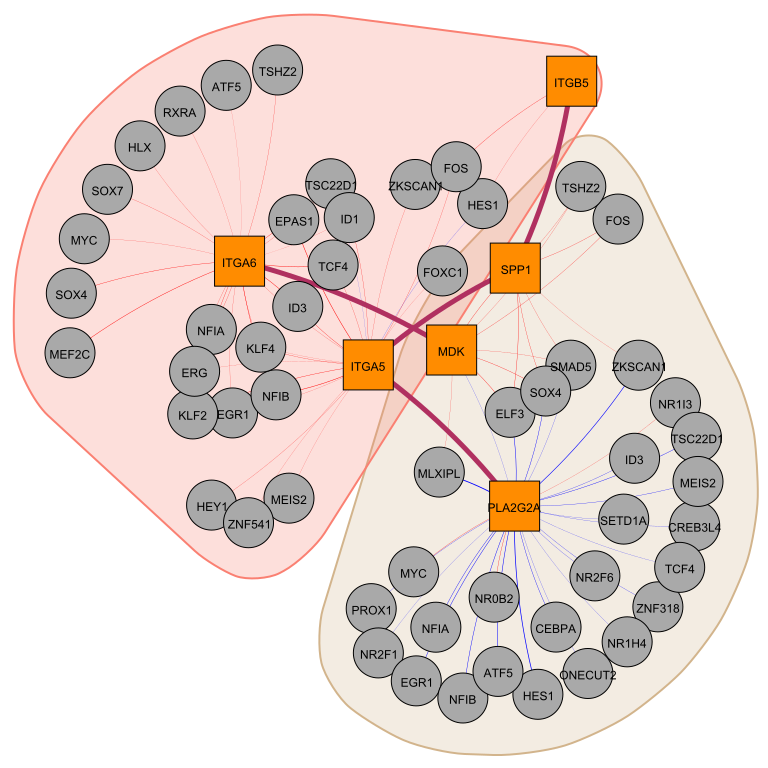

In [36]:
g1 = vis.plot_pcNet(obj_T, view='sender', gene_names=[targets[0][0], targets[6][0], targets[7][0], targets[9][0]], 
                    top_edges=40, show = False, verbose = True)
g2 = vis.plot_pcNet(obj_T, view='receiver', gene_names=[targets[0][1], targets[6][1], targets[7][1], targets[9][1]], 
                    top_edges=40, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[0], targets[6], targets[7], targets[9]], 
              verbose = True, edge_width_scale=scale_factor, mark_color = ["tan", "salmon"])
# , saveas='HCC_Hep2Endo')

In [37]:
g11 = vis.plot_pcNet(obj_N, view='sender', gene_names=[targets[0][0], targets[6][0], targets[7][0]], 
              match_fig=g1, show = False, verbose = True, edge_width_scale=scale_factor)

g22 = vis.plot_pcNet(obj_N, view='receiver', gene_names=[targets[0][1], targets[6][1], targets[7][1]], 
             match_fig=g2, show = False, verbose = True, edge_width_scale=scale_factor)

vis.plot_XNet(g11, g22, Xct_pair = [targets[0], targets[6], targets[7]], verbose = True, edge_width_scale=scale_factor)

identified 139 TF(s) along with 3 ligand/receptor target gene(s)


ValueError: target gene PLA2G2A MDK SPP1 generated 0 edge...

identified 140 TF(s) along with 4 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 27, # of edges: 26



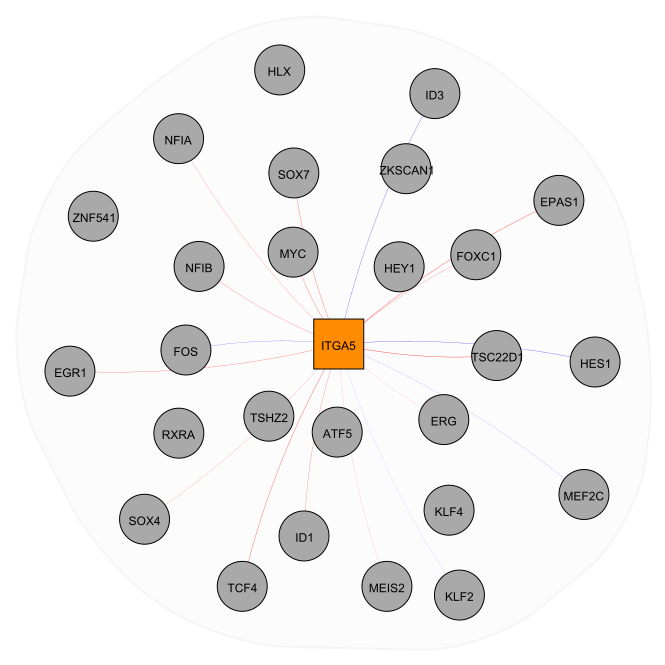

In [38]:
vis.plot_pcNet(obj_N, view='receiver', gene_names=[targets[1][1], targets[2][1], targets[5][1], targets[7][1]], 
             match_fig=g2, bbox_scale=1.3, show = True, verbose = True, edge_width_scale=scale_factor)

In [39]:
scale_factor = 80

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 11, # of edges: 10

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 11, # of edges: 10

graphs merged: 
# of nodes: 22, # of edges: 20

edge from IGF2 to PDGFRB added


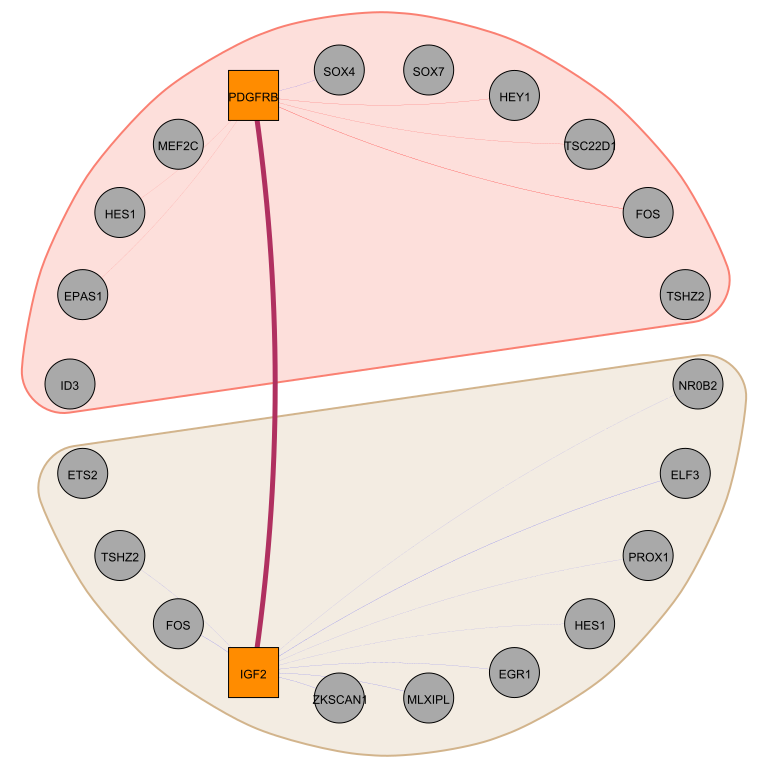

In [40]:
g1 = vis.plot_pcNet(obj_T, view='sender', gene_names=[targets[2][0]], top_edges=10, show = False, verbose = True)
g2 = vis.plot_pcNet(obj_T, view='receiver', gene_names=[targets[2][1]], top_edges=10, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[2]], verbose = True, edge_width_scale=scale_factor,
             layout='circle', mark_color = ["tan", "salmon"])
# , saveas='HCC_Hep2Endo_IGF2_T')

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 11, # of edges: 8

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 11, # of edges: 10

graphs merged: 
# of nodes: 22, # of edges: 18

edge from IGF2 to PDGFRB added


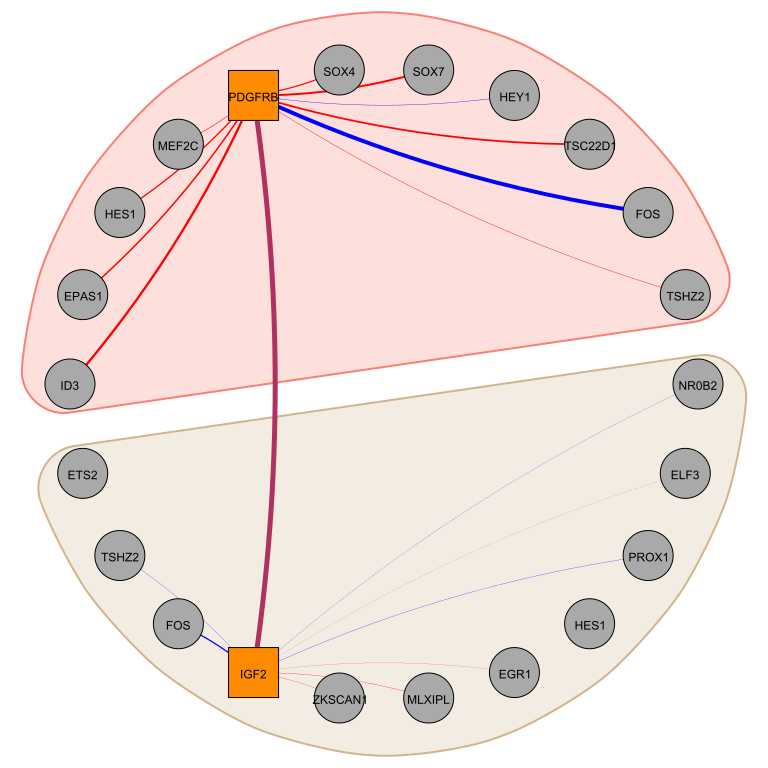

In [41]:
g11 = vis.plot_pcNet(obj_N, view='sender', gene_names=[targets[2][0]], remove_isolated_nodes = False,
              match_fig=g1, show = False, verbose = True, edge_width_scale=scale_factor)

g22 = vis.plot_pcNet(obj_N, view='receiver', gene_names=[targets[2][1]], 
             match_fig=g2, show = False, verbose = True, edge_width_scale=scale_factor)

vis.plot_XNet(g11, g22, Xct_pair = [targets[2]], verbose = True, edge_width_scale=scale_factor,
             layout='circle', mark_color = ["tan", "salmon"]) 
# saveas='HCC_Hep2Endo_IGF2_N')

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 11, # of edges: 10

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 11, # of edges: 10

graphs merged: 
# of nodes: 22, # of edges: 20

edge from IGF2 to PDGFRB added


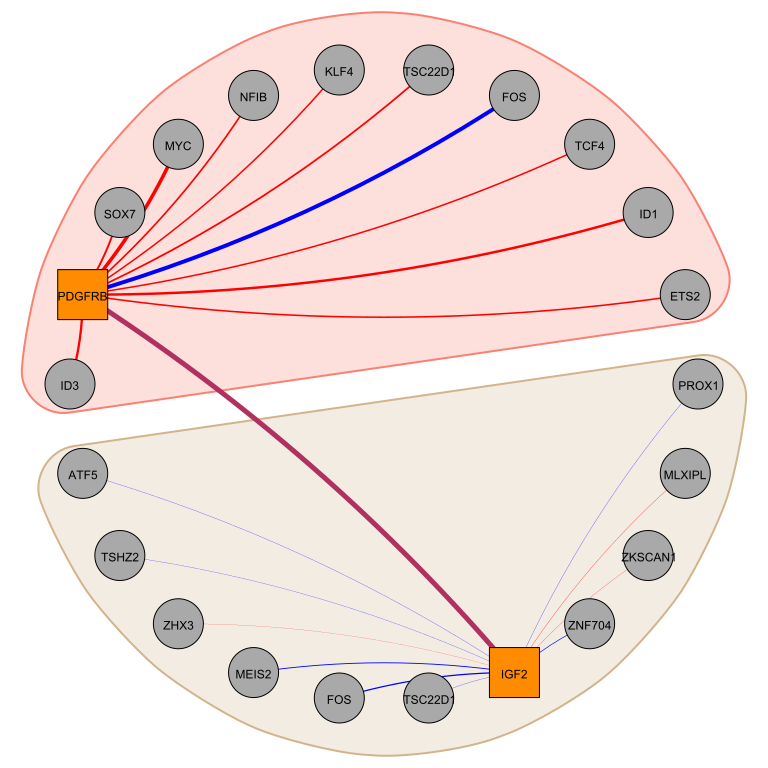

In [42]:
g1 = vis.plot_pcNet(obj_N, view='sender', gene_names=[targets[2][0]], top_edges=10, show = False, verbose = True)
g2 = vis.plot_pcNet(obj_N, view='receiver', gene_names=[targets[2][1]], top_edges=10, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[2]], verbose = True, edge_width_scale=scale_factor,
             layout='circle', mark_color = ["tan", "salmon"])
# , saveas='HCC_Hep2Endo_IGF2_N_new')

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 11, # of edges: 10

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 11, # of edges: 10

graphs merged: 
# of nodes: 22, # of edges: 20

edge from IGF2 to PDGFRB added


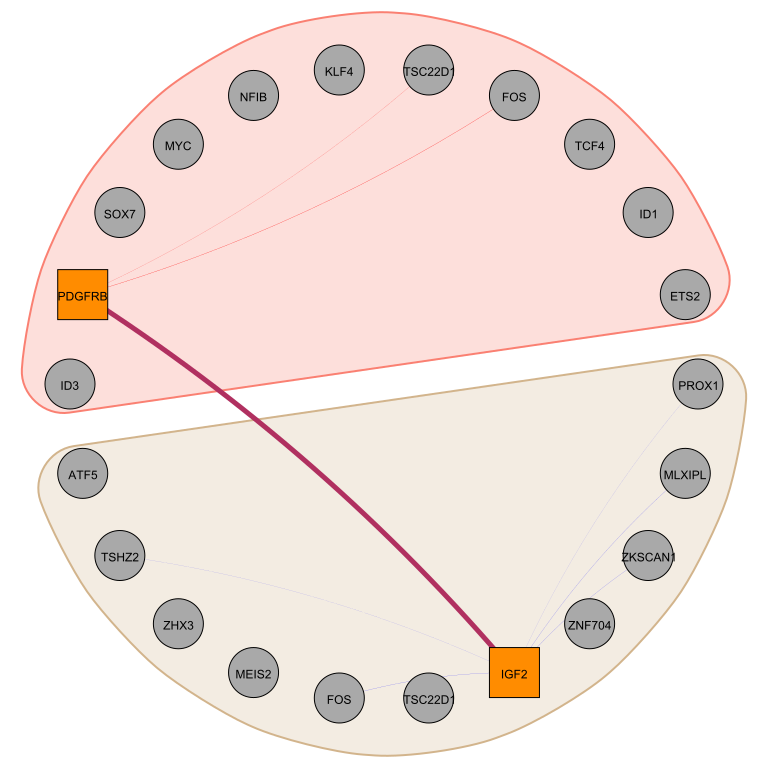

In [43]:
g11 = vis.plot_pcNet(obj_T, view='sender', gene_names=[targets[2][0]], remove_isolated_nodes = False,
              match_fig=g1, show = False, verbose = True, edge_width_scale=scale_factor)

g22 = vis.plot_pcNet(obj_T, view='receiver', gene_names=[targets[2][1]], 
             match_fig=g2, show = False, verbose = True, edge_width_scale=scale_factor)

vis.plot_XNet(g11, g22, Xct_pair = [targets[2]], verbose = True, edge_width_scale=scale_factor,
             layout='circle', mark_color = ["tan", "salmon"])
# , saveas='HCC_Hep2Endo_IGF2_T_new')